In [1]:
import pandas as pd
import csv
import time
from sklearn.model_selection import train_test_split

import warnings
##visulation of NA
import missingno


# check version number
import imblearn
print(imblearn.__version__)

from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


Bad key "text.kerning_factor" on line 4 in
/Users/apple/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


0.8.0


In [2]:
# load data
train = pd.read_csv("train.csv", header = None)

test = pd.read_csv("test.csv", header = None)

print(test.info())
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2959 entries, 0 to 2958
Columns: 961 entries, 0 to 960
dtypes: float64(960), int64(1)
memory usage: 21.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Columns: 962 entries, 0 to 961
dtypes: float64(960), int64(2)
memory usage: 68.9 MB


In [3]:
# minor_size is number of classes less than 500 instances
minor_size = 0
grouped = train.groupby(train.columns[-1])
for k,group in grouped:
        if len(group.index) < 500:
            minor_size += 1
        print ("Class label: ",k,end='')
        print("  Number:",len(group.index), end='')
        print(" (%.3f%%)" %  float(len(group.index)/len(train)*100))
minor_size

Class label:  1  Number: 578 (6.157%)
Class label:  2  Number: 579 (6.167%)
Class label:  3  Number: 590 (6.285%)
Class label:  4  Number: 571 (6.082%)
Class label:  5  Number: 577 (6.146%)
Class label:  6  Number: 580 (6.178%)
Class label:  7  Number: 570 (6.072%)
Class label:  8  Number: 580 (6.178%)
Class label:  9  Number: 586 (6.242%)
Class label:  10  Number: 579 (6.167%)
Class label:  11  Number: 190 (2.024%)
Class label:  12  Number: 195 (2.077%)
Class label:  13  Number: 196 (2.088%)
Class label:  14  Number: 190 (2.024%)
Class label:  15  Number: 190 (2.024%)
Class label:  16  Number: 194 (2.066%)
Class label:  17  Number: 193 (2.056%)
Class label:  18  Number: 190 (2.024%)
Class label:  19  Number: 193 (2.056%)
Class label:  20  Number: 195 (2.077%)
Class label:  21  Number: 98 (1.044%)
Class label:  22  Number: 97 (1.033%)
Class label:  23  Number: 97 (1.033%)
Class label:  24  Number: 98 (1.044%)
Class label:  25  Number: 96 (1.023%)
Class label:  26  Number: 98 (1.044%)
C

39

## Split Data

In [4]:
# exclude sample ID (1st column)
x_train_valid = train.iloc[:,1:-1].to_numpy()
y_train_valid = train.iloc[:,-1].to_numpy()

#split a validation set for hyper-parameter tuning
split_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train_valid, y_train_valid, test_size=split_ratio, random_state=1,stratify = y_train_valid) 


x_test = test.iloc[:,1:].to_numpy()


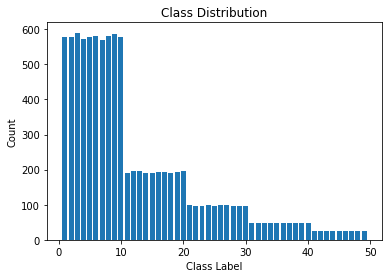

In [5]:
# summarize distribution
fig, p = pyplot.subplots()
counter = Counter(y_train_valid)
pyplot.bar(counter.keys(), counter.values())
p.set_title('Class Distribution')
p.set_ylabel('Count')
p.set_xlabel('Class Label')
pyplot.show()

### Apply SMOTE

In [6]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE

# we only oversample during training
ada = ADASYN(random_state = 42, sampling_strategy = 'minority', n_neighbors=5)
bdsmt = BorderlineSMOTE(random_state = 42)
smt = SMOTE(random_state = 42)

x_ada_train = x_train.copy()
y_ada_train = y_train.copy()

x_bdsmt_train = x_train.copy()
y_bdsmt_train = y_train.copy()

x_smt_train = x_train.copy()
y_smt_train = y_train.copy()

# ada failed to resample all minority class at once, we manually resample minority classes(less than 500 instances)
for i in range(minor_size):
    x_ada_train, y_ada_train = ada.fit_resample(x_ada_train, y_ada_train)
    
    
x_bdsmt_train, y_bdsmt_train = bdsmt.fit_resample(x_bdsmt_train, y_bdsmt_train)
x_smt_train, y_smt_train = smt.fit_resample(x_smt_train, y_smt_train)

#print("ada size: ", len(x_ada_train))
#print("bdsmt size: ", len(x_bdsmt_train))
print("ada size: ", len(y_ada_train))
print("bdsmt size: ", len(y_bdsmt_train))
print("smt size: ", len(y_smt_train))


counter = Counter(y_bdsmt_train)
for k,v in counter.items():
    per = v / len(y_bdsmt_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))


ada size:  25076
bdsmt size:  22222
smt size:  23128
Class=3, n=472 (2.124%)
Class=9, n=472 (2.124%)
Class=17, n=472 (2.124%)
Class=7, n=472 (2.124%)
Class=2, n=472 (2.124%)
Class=30, n=472 (2.124%)
Class=20, n=472 (2.124%)
Class=25, n=472 (2.124%)
Class=45, n=472 (2.124%)
Class=1, n=472 (2.124%)
Class=14, n=472 (2.124%)
Class=26, n=472 (2.124%)
Class=5, n=472 (2.124%)
Class=13, n=472 (2.124%)
Class=41, n=472 (2.124%)
Class=18, n=472 (2.124%)
Class=34, n=472 (2.124%)
Class=24, n=472 (2.124%)
Class=22, n=472 (2.124%)
Class=23, n=472 (2.124%)
Class=8, n=472 (2.124%)
Class=4, n=472 (2.124%)
Class=6, n=472 (2.124%)
Class=33, n=472 (2.124%)
Class=11, n=472 (2.124%)
Class=12, n=472 (2.124%)
Class=19, n=472 (2.124%)
Class=15, n=472 (2.124%)
Class=36, n=472 (2.124%)
Class=29, n=472 (2.124%)
Class=16, n=472 (2.124%)
Class=10, n=472 (2.124%)
Class=37, n=472 (2.124%)
Class=38, n=472 (2.124%)
Class=49, n=19 (0.086%)
Class=39, n=472 (2.124%)
Class=47, n=472 (2.124%)
Class=28, n=472 (2.124%)
Class=4

### Normalizing and PCA

In [7]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np


pca = PCA(n_components=300)
#pca = PCA(n_components = 'mle')

# normalize data first, then PCA
x_ada_train_norm = preprocessing.normalize(x_ada_train)
x_bdsmt_train_norm = preprocessing.normalize(x_bdsmt_train)
x_val_norm = preprocessing.normalize(x_val)
# PCA data
x_ada_train_pca =  pca.fit_transform(x_ada_train_norm)
x_bdsmt_train_pca =  pca.fit_transform(x_bdsmt_train_norm)
x_val_pca = pca.fit_transform(x_val_norm)

print(x_ada_train_pca.shape, x_bdsmt_train_pca.shape)

(25076, 300) (22222, 300)


## Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def one_hot_encode(class_set):
    encoder = LabelEncoder()
    encoder.fit(class_set)
    encoded_Y = encoder.transform(class_set)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y

y_ada_train_encoded = one_hot_encode(y_ada_train)
y_bdsmt_train_encoded = one_hot_encode(y_bdsmt_train)
y_val_encoded = one_hot_encode(y_val)

## Modelling

### Random Forest

- option 1: RandomForestClassifier applies on SMOTE data (sampling method)
    - BDLine_SMOTE perform the best
    - no change after scaled
    - best: n_estimators=750, min_samples_split=4, n_jobs = -1
- option 2: RandomForestClassifier applies on unbalanced data with weight (cost sensitive method)
    - 2.1 balanced
    - 2.2 balanced_subsample
- option 3: BalancedRandomForestClassifier applies on unbalanced data

- n_estimators, min_samples_split, n_jobs are influencial parameters

In [12]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import time

In [13]:
Test_Accuracy_Data = pd.DataFrame(columns = ['option','n_estimators','max_depth','random_state',
                                             'min_samples_leaf','min_samples_split','max_samples',
                                             'criterion','n_jobs','Train ACC','Val ACC', 
                                             'F1', 'Recall'])

### Option 1

In [19]:
trainStartTime = time.time()

option = 'option 1'

trainStartTime = time.time()


n_estimators = 500

max_depth = None

random_state = 0

min_samples_leaf = 1

min_samples_split = 6

max_samples = None

criterion = 'gini'

n_jobs = -1


rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                             random_state = random_state, min_samples_leaf = min_samples_leaf,
                             min_samples_split = min_samples_split,
                             max_samples = max_samples, criterion = criterion, n_jobs = n_jobs)


model= rfc.fit(x_bdsmt_train, y_bdsmt_train)

Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['option','n_estimators','max_depth',
                                                                      'random_state', 
                                                                      'min_samples_leaf','min_samples_split',
                                                                      'max_samples','criterion', 'n_jobs'
                                                                      'Train ACC','Val ACC', 'F1', 'Recall'])

Test_Accuracy_Data_One.loc[:,'option'] = option
Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
Test_Accuracy_Data_One.loc[:,'random_state'] = random_state            
Test_Accuracy_Data_One.loc[:,'min_samples_leaf'] = min_samples_leaf
Test_Accuracy_Data_One.loc[:,'min_samples_split'] = min_samples_split
Test_Accuracy_Data_One.loc[:,'max_samples'] = max_samples       
Test_Accuracy_Data_One.loc[:,'criterion'] = criterion 
Test_Accuracy_Data_One.loc[:,'n_jobs'] = n_jobs


train_pre = rfc.predict(x_bdsmt_train)
train_acc = rfc.score(x_bdsmt_train, y_bdsmt_train)
train_acc1 = accuracy_score(y_bdsmt_train, train_pre)

predictions = rfc.predict(x_val)
acc = rfc.score(x_val, y_val)
acc1 = accuracy_score(y_val, predictions)


#f1 = metrics.f1_score(y_val, predictions)
#recall = metrics.recall_score(y_val, predictions)

Test_Accuracy_Data_One.loc[:,'Train ACC'] = train_acc
Test_Accuracy_Data_One.loc[:,'Val ACC'] = acc
#Test_Accuracy_Data_One.loc[:,'F1'] = f1
#Test_Accuracy_Data_One.loc[:,'Recall'] = recall 

Test_Accuracy_Data = Test_Accuracy_Data.append(Test_Accuracy_Data_One)
            
print(train_acc1)
print(acc1)

trainFinishTime = time.time()
print("Time spent on training is: " + str(trainFinishTime - trainStartTime) + " sec")

Test_Accuracy_Data


/Users/apple/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


0.999909999099991
0.43610223642172524
Time spent on training is: 1935.612566947937 sec


,F1,Recall,Train ACC,Val ACC,criterion,max_depth,max_samples,min_samples_leaf,min_samples_split,n_estimators,n_jobs,n_jobsTrain ACC,option,random_state
0,NaN,NaN,1.00000,0.100106,gini,None,None,1,2,50,-1.0,NaN,option 1-pca,0
0,NaN,NaN,0.99595,0,gini,None,None,1,2,50,-1.0,NaN,option 1-pca,0
0,NaN,NaN,1.00000,0.437167,gini,None,None,1,4,300,-1.0,NaN,option 1,0
0,NaN,NaN,1.00000,0.447284,gini,None,None,1,4,500,-1.0,NaN,option 1,0
0,NaN,NaN,0.99991,0.436102,gini,None,None,1,6,500,-1.0,NaN,option 1,0


### Hyperparameter Tuning

In [20]:
# hyperparameters tuning
#!pip install hyperopt

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize the range of values
space={'n_estimators': hp.quniform("n_estimators", 200, 500, 1),
        'min_samples_split' : hp.quniform('min_samples_split', 2, 8, 1)}


def objective(space):
    rfc=RandomForestClassifier(n_estimators =int(space['n_estimators']), max_depth = None,
                             min_samples_leaf = 1,
                             min_samples_split=int(space['min_samples_split']),
                             max_samples= None, n_jobs=-1, criterion='gini', random_state = 0)
    
    #evaluation = [(x_bdsmt_train, y_bdsmt_train), ( x_val, y_val)]
    rfc.fit(x_bdsmt_train, y_bdsmt_train)
    pred = rfc.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest,max_evals = 50,trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best)

SCORE:                                                
0.4329073482428115                                    
SCORE:                                                                              
0.44515441959531415                                                                 
SCORE:                                                                               
0.43610223642172524                                                                  
SCORE:                                                                               
0.43929712460063897                                                                  
SCORE:                                                                               
0.4414270500532481                                                                     
SCORE:                                                                                 
0.4387646432374867                                                                     
SCORE:                    

In [ ]:
#grid search for hyperparameter tunning
from sklearn.model_selection import GridSearchCV as gsc

trainStartTime = time.time()

# function for acc
def acc_score(cl,x,y):
    pred = cl.predict(x_val)
    acc=cl.score(x_val,y_val)
    print(cl, acc)
    return acc


parameters = {'n_estimators':[200, 500, 750],'min_samples_split':[2,4,6]}

rfc = RandomForestClassifier(max_features="auto", random_state=0, n_jobs = -1)
clf = gsc(rfc, parameters, n_jobs=-1, scoring=acc_score, verbose=10)

clf.fit(x_bdsmt_train,y_bdsmt_train)
pre=clf.predict(x_val)
print(clf.best_params_)

trainFinishTime = time.time()
print("Time spent on training is: " + str(trainFinishTime - trainStartTime) + " sec")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


## Option 2

In [18]:
trainStartTime = time.time()

option = 'option 2.2'

trainStartTime = time.time()


n_estimators = 200

max_depth = None

random_state = 0

min_samples_leaf = 1

min_samples_split = 4

max_samples = None

criterion = 'gini'

n_jobs = -1

#option 2.1
#class_weight = 'balanced'
#option 2.2
class_weight = 'balanced_subsample'


rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                             random_state = random_state, min_samples_leaf = min_samples_leaf,
                             min_samples_split = min_samples_split, class_weight = class_weight,
                             max_samples = max_samples, criterion = criterion, n_jobs = n_jobs)

#Fit the classifier to the training set
model= rfc.fit(x_train, y_train)

Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['option','n_estimators','max_depth',
                                                                      'random_state', 
                                                                      'min_samples_leaf','min_samples_split',
                                                                      'max_samples','criterion', 'n_jobs'
                                                                      'Train ACC','Val ACC', 'F1', 'Recall'])

Test_Accuracy_Data_One.loc[:,'option'] = option
Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
Test_Accuracy_Data_One.loc[:,'random_state'] = random_state            
Test_Accuracy_Data_One.loc[:,'min_samples_leaf'] = min_samples_leaf
Test_Accuracy_Data_One.loc[:,'min_samples_split'] = min_samples_split
Test_Accuracy_Data_One.loc[:,'max_samples'] = max_samples       
Test_Accuracy_Data_One.loc[:,'criterion'] = criterion 
Test_Accuracy_Data_One.loc[:,'n_jobs'] = n_jobs


train_pre = rfc.predict(x_train)
train_acc = rfc.score(x_train, y_train)
train_acc1 = accuracy_score(y_train, train_pre)

predictions = rfc.predict(x_val)
acc = rfc.score(x_val, y_val)
acc1 = accuracy_score(y_val, predictions)


#f1 = metrics.f1_score(y_val, predictions)
#recall = metrics.recall_score(y_val, predictions)

Test_Accuracy_Data_One.loc[:,'Train ACC'] = train_acc
Test_Accuracy_Data_One.loc[:,'Val ACC'] = acc
#Test_Accuracy_Data_One.loc[:,'F1'] = f1
#Test_Accuracy_Data_One.loc[:,'Recall'] = recall 

Test_Accuracy_Data = Test_Accuracy_Data.append(Test_Accuracy_Data_One)
            
print(train_acc1)
print(acc1)

trainFinishTime = time.time()
print("Time spent on training is: " + str(trainFinishTime - trainStartTime) + " sec")

Test_Accuracy_Data


1.0
0.4323748668796592
Time spent on training is: 78.22255182266235 sec


/Users/apple/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,F1,Recall,Train ACC,Val ACC,criterion,max_depth,max_samples,min_samples_leaf,min_samples_split,n_estimators,n_jobs,n_jobsTrain ACC,option,random_state
0,NaN,NaN,1.000000,0.432375,gini,None,None,1,4,200,-1.0,NaN,option 2,0
0,NaN,NaN,1.000000,0.43131,gini,None,None,1,4,200,-1.0,NaN,option 2.1,0
0,NaN,NaN,0.562051,0.239084,gini,None,None,1,4,200,-1.0,NaN,option 3,0
0,NaN,NaN,1.000000,0.43131,gini,None,None,1,4,200,-1.0,NaN,option 2.1,0
0,NaN,NaN,1.000000,0.432375,gini,None,None,1,4,200,-1.0,NaN,option 2.2,0


## Option 3

In [16]:
trainStartTime = time.time()

option = 'option 3'

trainStartTime = time.time()


n_estimators = 200

max_depth = None

random_state = 0

min_samples_leaf = 1

min_samples_split = 4

max_samples = None

criterion = 'gini'

n_jobs = -1



rfc = BalancedRandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                             random_state = random_state, min_samples_leaf = min_samples_leaf,
                             min_samples_split = min_samples_split,
                             max_samples = max_samples, criterion = criterion, n_jobs = n_jobs)


model= rfc.fit(x_train, y_train)

Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['option','n_estimators','max_depth',
                                                                      'random_state', 
                                                                      'min_samples_leaf','min_samples_split',
                                                                      'max_samples','criterion', 'n_jobs'
                                                                      'Train ACC','Val ACC', 'F1', 'Recall'])

Test_Accuracy_Data_One.loc[:,'option'] = option
Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
Test_Accuracy_Data_One.loc[:,'random_state'] = random_state            
Test_Accuracy_Data_One.loc[:,'min_samples_leaf'] = min_samples_leaf
Test_Accuracy_Data_One.loc[:,'min_samples_split'] = min_samples_split
Test_Accuracy_Data_One.loc[:,'max_samples'] = max_samples       
Test_Accuracy_Data_One.loc[:,'criterion'] = criterion 
Test_Accuracy_Data_One.loc[:,'n_jobs'] = n_jobs


train_pre = rfc.predict(x_train)
train_acc = rfc.score(x_train, y_train)
train_acc1 = accuracy_score(y_train, train_pre)

predictions = rfc.predict(x_val)
acc = rfc.score(x_val, y_val)
acc1 = accuracy_score(y_val, predictions)


#f1 = metrics.f1_score(y_val, predictions)
#recall = metrics.recall_score(y_val, predictions)

Test_Accuracy_Data_One.loc[:,'Train ACC'] = train_acc
Test_Accuracy_Data_One.loc[:,'Val ACC'] = acc
#Test_Accuracy_Data_One.loc[:,'F1'] = f1
#Test_Accuracy_Data_One.loc[:,'Recall'] = recall 

Test_Accuracy_Data = Test_Accuracy_Data.append(Test_Accuracy_Data_One)
            
print(train_acc1)
print(acc1)

trainFinishTime = time.time()
print("Time spent on training is: " + str(trainFinishTime - trainStartTime) + " sec")

Test_Accuracy_Data

0.5620505992010653
0.23908413205537807
Time spent on training is: 11.269511938095093 sec


/Users/apple/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,F1,Recall,Train ACC,Val ACC,criterion,max_depth,max_samples,min_samples_leaf,min_samples_split,n_estimators,n_jobs,n_jobsTrain ACC,option,random_state
0,NaN,NaN,1.000000,0.432375,gini,None,None,1,4,200,-1.0,NaN,option 2,0
0,NaN,NaN,1.000000,0.43131,gini,None,None,1,4,200,-1.0,NaN,option 2.1,0
0,NaN,NaN,0.562051,0.239084,gini,None,None,1,4,200,-1.0,NaN,option 3,0


## Output Final Result

In [21]:
# test on the test data
predictions=rfc.predict(x_test)

with open("rf_out500_6.csv","w", newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Category"])
    test_id = 0
    for pred in predictions:
        writer.writerow([test_id, pred])
        test_id+=1